# This notebook builds a general stock market RNN then finetunes it for a particular basket of stocks

In [48]:
import tensorflow as tf
import os
from datetime import datetime
from pandas_datareader.exceptions import DEP_ERROR_MSG, ImmediateDeprecationError

In [49]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import signal
import pickle

In [50]:
import pandas as pd

## I run Tensorflow in Nvidia-Docker, which doesn't come with pandas_datareader installed 

In [51]:
!pip install pandas_datareader

In [52]:
from pandas_datareader import data as web

In [53]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (22, 9)
start = datetime(2018,9,1)
stop = datetime(202,5,5)

In [54]:
# 'MSFT', 'GPRO', 'SBUX', 'BABA','FIT','GE','LUV''BAC','RTX','TWTR','DIS','AAPL', 'NFLX',

os.environ['ALPHAVANTAGE_API_KEY'] = "XFF5HEBRJ25DX4NR"

In [55]:
tsla = web.DataReader("TSLA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [56]:
# TODO: Should duplicate items in the basket in different orders to expand the training set

In [57]:
googl = web.DataReader("GOOGL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [58]:
fb = web.DataReader("FB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [59]:
twtr = web.DataReader("TWTR", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [60]:
rtx = web.DataReader("RTX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [61]:
aapl = web.DataReader("AAPL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [62]:
invvy = web.DataReader("INVVY", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
bac = web.DataReader("BAC", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
huya = web.DataReader("HUYA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [63]:
sgh = web.DataReader("SGH", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
uber= web.DataReader("UBER", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
snap = web.DataReader("SNAP", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [65]:
sedg = web.DataReader("SEDG", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
acb = web.DataReader("ACB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
baba = web.DataReader("BABA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [66]:
aapl = aapl.copy()
aapl = aapl.reset_index()

tsla = tsla.copy()
tsla=tsla.reset_index()

fb = fb.copy()
fb=fb.reset_index()

rtx = rtx.copy()
rtx=rtx.reset_index()

aapl = aapl.copy()
aapl=aapl.reset_index()

twtr = twtr.copy()
twtr = twtr.reset_index()

googl = googl.copy()
googl=googl.reset_index()

sgh = sgh.copy()
sgh=sgh.reset_index()

invvy = invvy.copy()
invvy=invvy.reset_index()

bac = bac.copy()
bac=bac.reset_index()

huya = huya.copy()
huya=huya.reset_index()

uber = uber.copy()
uber=uber.reset_index()

snap = snap.copy()
snap=snap.reset_index()

sedg = sedg.copy()
sedg=sedg.reset_index()

acb = acb.copy()
acb=acb.reset_index()

baba = baba.copy()
baba=baba.reset_index()

In [68]:

basket = ['TSLA', 'GOOGL', 'FB','RTX','TWTR','AAPL', 'INVVY','BAC','HUYA','SGH','UBER','SNAP']



aapl['symbol'] = "AAPL"
googl['symbol'] ='GOOGL'
fb['symbol'] = 'FB'
twtr['symbol'] ='TWTR'
rtx['symbol'] ='RTX'
tsla['symbol'] = 'TSLA'
invvy['symbol'] = 'INVVY'
bac['symbol'] = 'BAC'
huya['symbol'] = 'HUYA'
sgh['symbol'] = 'SGH'
uber['symbol'] = 'UBER'
snap['symbol'] = 'SNAP'

df = pd.concat([googl,fb,twtr,rtx,aapl,tsla, googl, sgh, invvy, bac, huya, uber, snap], ignore_index = True)
sum(df['symbol']=='GOOGL')

7936

In [69]:
df[df['symbol']=='TWTR']

,index,open,high,low,close,volume,symbol,level_0
5984,2013-11-07,45.10,50.090,44.000,44.90,117701600,TWTR,NaN
5985,2013-11-08,45.93,46.940,40.685,41.65,27925300,TWTR,NaN
5986,2013-11-11,40.50,43.000,39.400,42.90,16113900,TWTR,NaN
5987,2013-11-12,43.66,43.780,41.830,41.90,6316700,TWTR,NaN
5988,2013-11-13,41.03,42.870,40.760,42.60,8688300,TWTR,NaN
...,...,...,...,...,...,...,...,...
7625,2020-05-18,29.70,30.285,29.560,29.64,15772313,TWTR,NaN
7626,2020-05-19,29.70,30.350,29.325,29.88,17361481,TWTR,NaN
7627,2020-05-20,30.50,32.350,30.450,32.23,26914701,TWTR,NaN
7628,2020-05-21,32.10,32.610,31.390,32.34,22850684,TWTR,NaN


# Feature engineering

De-trend and add a few extra features

In [70]:
X_scalers = {}
y_scalers = {}
for stock in basket:
    for col in ('close', 'high', 'low', 'open', 'volume'):
        df[col] = df[col].astype(float)
        df.loc[df['symbol'] == stock, col] = signal.detrend(df[df['symbol'] == stock][col])
    df.loc[df['symbol'] == stock, 'mean_close_price_2'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=2).mean()
    df.loc[df['symbol'] == stock, 'mean_close_price_3'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=3).mean()
    df.loc[df['symbol'] == stock, 'std_close_price_2'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=2).std()
    df.loc[df['symbol'] == stock, 'std_close_price_3'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=3).std()

In [71]:
X_scalers = {stock:{} for stock in basket}
y_scalers = {}

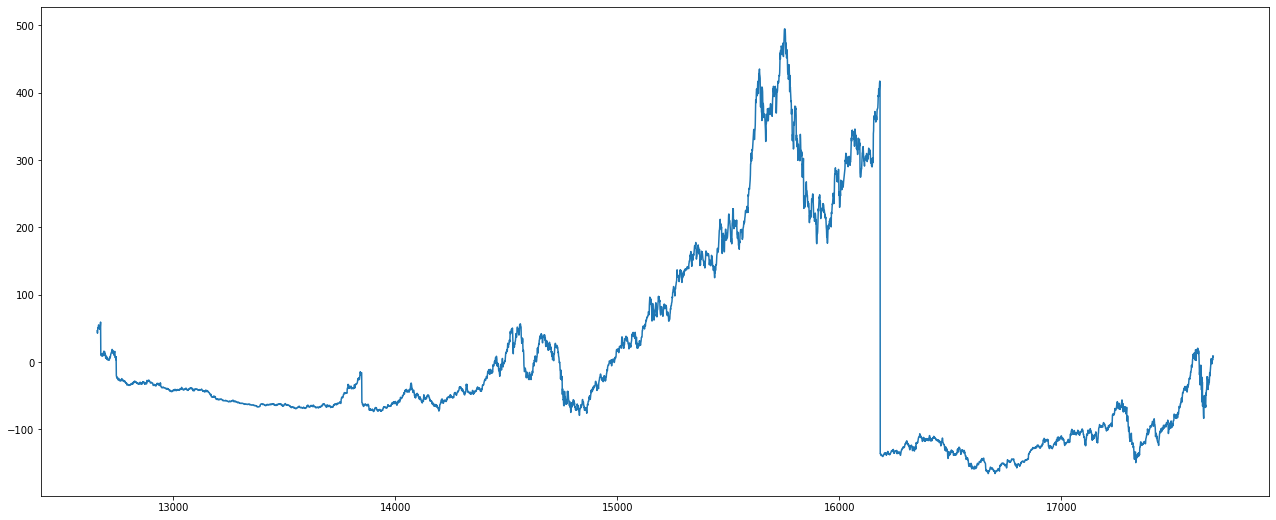

In [72]:
plt.plot(df[df['symbol'] == 'AAPL']['close'])
plt.show()

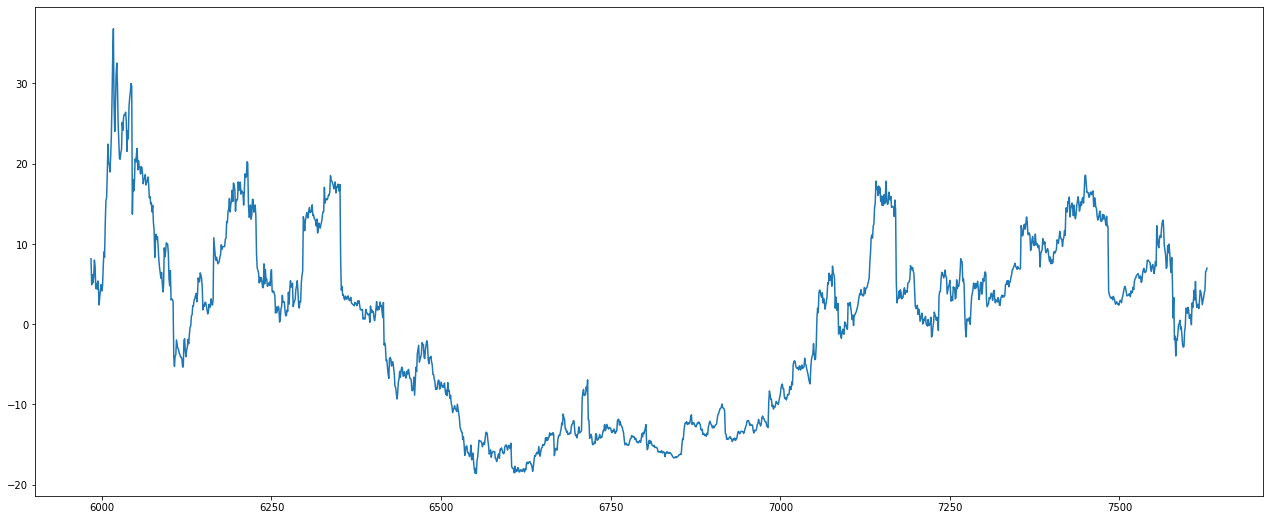

In [73]:
plt.plot(df[df['symbol'] == 'TWTR']['close'])
plt.show()

In [74]:
df['tomo_gain'] = df['close'].shift(-1) - df['close']
df['yday_gain'] = df['tomo_gain'].shift(1)

# This is not ok - note the last one

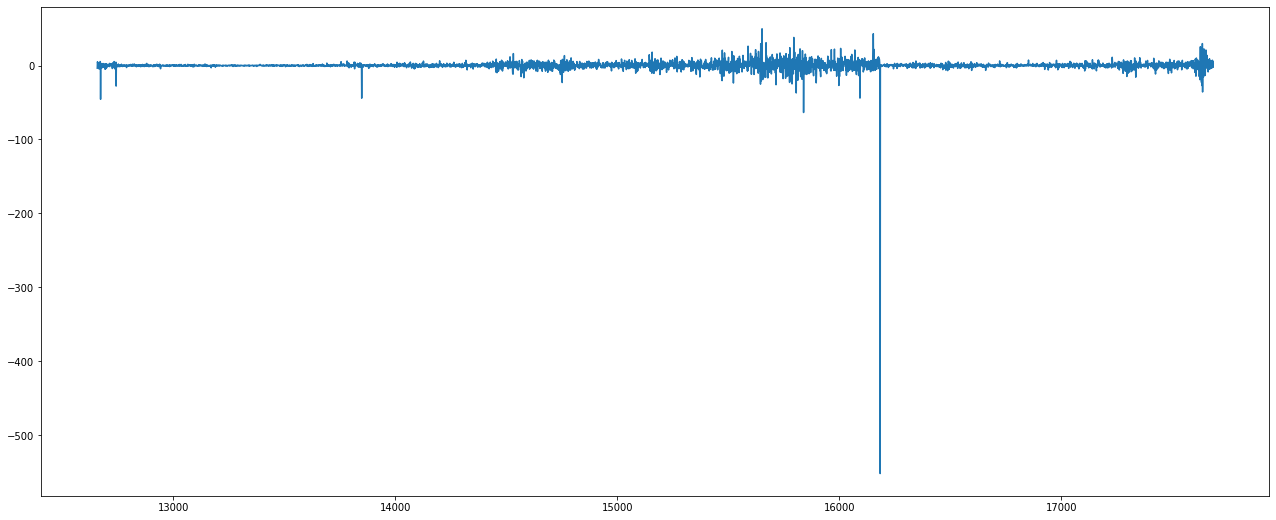

In [75]:
plt.plot(df[df['symbol'] == 'AAPL'][:-1]['tomo_gain'])
plt.show()

# This is better

In the for loop below, the last row of each stock symbol is dropped.

In [76]:
plt.show()
df[df['symbol']=='TWTR']

,index,open,high,low,close,volume,symbol,level_0,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain
5984,2013-11-07,8.283597,12.512817,7.991237,8.155845,9.380142e+07,TWTR,NaN,NaN,NaN,NaN,NaN,-3.243255,-14.634169
5985,2013-11-08,9.120401,9.369830,4.682793,4.912589,4.027552e+06,TWTR,NaN,6.534217,NaN,2.293328,NaN,1.256745,-3.243255
5986,2013-11-11,3.697205,5.436842,3.404350,6.169334,-7.781417e+06,TWTR,NaN,5.540962,6.412589,0.888653,1.635254,-0.993255,1.256745
5987,2013-11-12,6.864009,6.223855,5.840906,5.176079,-1.757619e+07,TWTR,NaN,5.672706,5.419334,0.702338,0.662746,0.706745,-0.993255
5988,2013-11-13,4.240813,5.320868,4.777462,5.882823,-1.520215e+07,TWTR,NaN,5.529451,5.742745,0.499744,0.511229,2.096745,0.706745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7625,2020-05-18,4.048725,4.215754,4.310185,3.963775,-4.138109e+06,TWTR,NaN,3.640402,3.383697,0.457318,0.549785,0.246745,0.646745
7626,2020-05-19,4.055529,4.287766,4.081742,4.210519,-2.546510e+06,TWTR,NaN,4.087147,3.830441,0.174475,0.461426,2.356745,0.246745
7627,2020-05-20,4.862333,6.294779,5.213298,6.567264,7.009141e+06,TWTR,NaN,5.388892,4.913853,1.666470,1.437201,0.116745,2.356745
7628,2020-05-21,6.469137,6.561792,6.159854,6.684008,2.947555e+06,TWTR,NaN,6.625636,5.820597,0.082551,1.395590,0.286745,0.116745


# Create datetime features

In [77]:
def completed_quarter(dt):
    prev_quarter_map = ((4, -1), (1, 0), (2, 0), (3, 0))
    quarter, yd = prev_quarter_map[(dt.month - 1) // 3]
    return  quarter

In [78]:

for stock in basket:
    days =[]
    weeks = []
    quarter = []
    as_date = []   
    for x in df.loc[df['symbol'] == stock,'index']:
        as_date.append(datetime.strptime(x, '%Y-%m-%d'))
    for date in as_date:
        days.append(date.day)
        weeks.append(date.isocalendar()[1])
        quarter.append(completed_quarter(date))
    df.loc[df['symbol'] == stock,'dayofweek'] = days
    df.loc[df['symbol'] == stock,'quarter'] = quarter
    df.loc[df['symbol'] == stock,'weekofyear'] = weeks


In [79]:
df.head()
df = df.drop(['level_0','index'],axis=1)
df = df.dropna(axis=0)
df[df['symbol'] == 'GOOGL']

,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
2,-342.743908,-344.810086,-339.174554,-343.799261,6.534483e+06,GOOGL,-344.315895,-347.127529,0.730631,4.897220,-4.586732,1.033268,23.0,2.0,35.0
3,-342.320591,-346.747176,-344.710835,-348.385994,3.526874e+06,GOOGL,-346.092628,-345.672595,3.243310,2.405995,1.073268,-4.586732,24.0,2.0,35.0
4,-348.857275,-350.404266,-344.457117,-347.312726,-2.530636e+06,GOOGL,-347.849360,-346.499327,0.758915,2.399113,1.853268,1.073268,25.0,2.0,35.0
5,-348.723958,-350.511356,-343.733398,-345.459458,-4.623245e+06,GOOGL,-346.386092,-347.052726,1.310458,1.480491,-1.816732,1.853268,26.0,2.0,35.0
6,-345.630641,-349.898446,-342.759679,-347.276191,-5.505154e+06,GOOGL,-346.367825,-346.682792,1.284624,1.059595,-4.196732,-1.816732,27.0,2.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24142,458.633134,481.804709,459.722436,482.150129,7.661650e+04,GOOGL,476.118495,468.726861,8.530018,14.152362,-10.836732,12.063268,18.0,1.0,21.0
24143,482.476450,481.477620,479.226155,471.313396,-6.993917e+05,GOOGL,476.731762,474.516795,7.662727,6.639046,34.703268,-10.836732,19.0,1.0,21.0
24144,486.099767,500.960530,492.829874,506.016664,-3.643179e+05,GOOGL,488.665030,486.493396,24.538916,17.754638,-2.466732,34.703268,20.0,1.0,21.0
24145,507.873083,505.333440,499.743592,503.549932,-7.388321e+05,GOOGL,504.783298,493.626664,1.744243,19.363177,6.433268,-2.466732,21.0,1.0,21.0


In [80]:
for stock in basket:
    df = df.drop(df.index[len(df[df['symbol'] == stock]) - 1], axis=0)
    outliers = abs(df[df['symbol'] == stock]['tomo_gain']) < df[df['symbol'] == stock]['tomo_gain'].std() * 3
    df[df['symbol'] == stock] = df[df['symbol'] == stock].loc[:, :][outliers]
    df = df.drop(df[df['symbol'] == stock].iloc[-1].name) # get rid of last because next is a different stock
    pre_y = df[df['symbol'] == stock]['tomo_gain'].values
    y_scalers[stock] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
    for col in ('close', 'high', 'low', 'open', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = df[df['symbol'] == stock][col]
        X_scalers[stock][col] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
        df.loc[df['symbol'] == stock, col] = X_scalers[stock][col].fit_transform(pre_x.values.reshape(-1,1))
    df.loc[df['symbol'] == stock, 'tomo_gain'] = y_scalers[stock].fit_transform(pre_y.reshape(-1, 1)).reshape(-1)

# Save the feature scalers

In [81]:
pickle.dump(X_scalers, open('x_scalers.pkl', 'wb'))
pickle.dump(y_scalers, open('y_scalers.pkl', 'wb'))

# Note same shape but now different scale

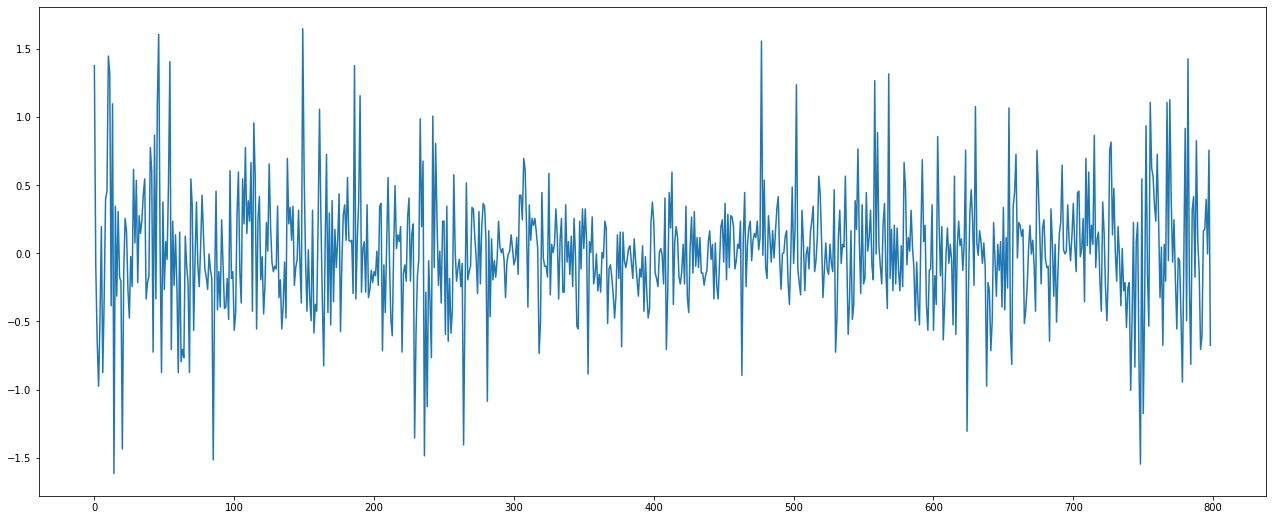

In [82]:
plt.plot(pre_y)
plt.show()

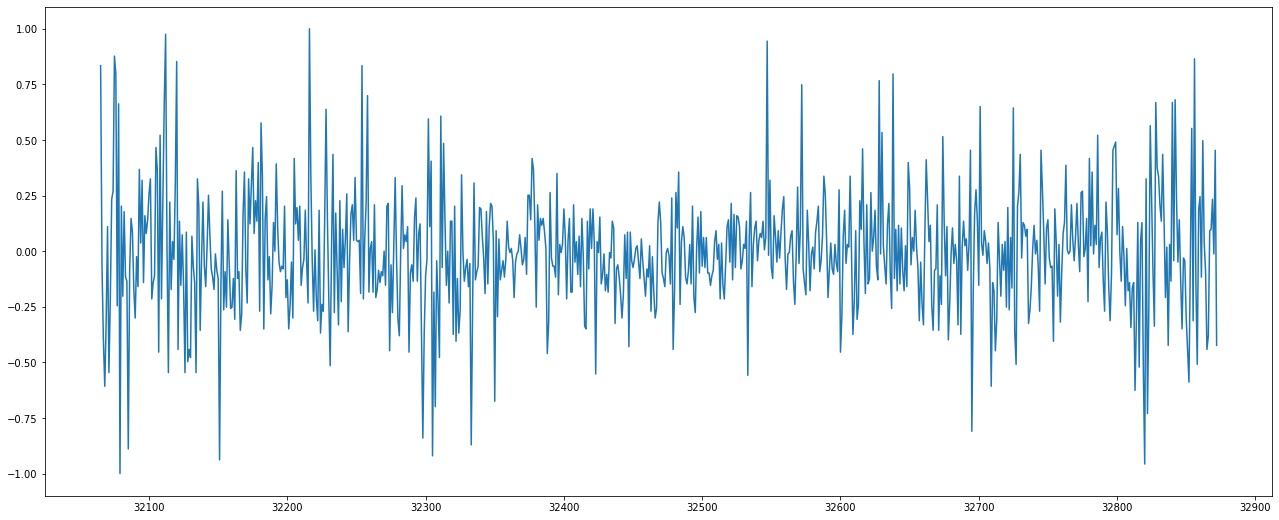

In [83]:

plt.plot( df.loc[df['symbol'] == basket[-1], 'tomo_gain'])

In [84]:
df = df.dropna(axis=0)

In [85]:
df.head()


,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
2,-0.669044,-0.666838,-0.669230,-0.671144,-0.644263,GOOGL,-0.672136,-0.675686,-0.998431,-0.987271,-0.091896,0.778523,23.0,2.0,35.0
3,-0.668453,-0.669540,-0.676979,-0.677562,-0.715888,GOOGL,-0.674628,-0.673643,-0.993018,-0.993860,0.012234,0.768280,24.0,2.0,35.0
4,-0.677579,-0.674643,-0.676624,-0.676060,-0.860146,GOOGL,-0.677092,-0.674804,-0.998370,-0.993878,0.026584,0.778596,25.0,2.0,35.0
5,-0.677393,-0.674792,-0.675611,-0.673467,-0.909981,GOOGL,-0.675040,-0.675581,-0.997182,-0.996308,-0.040935,0.780017,26.0,2.0,35.0
6,-0.673074,-0.673937,-0.674248,-0.676009,-0.930984,GOOGL,-0.675014,-0.675061,-0.997238,-0.997422,-0.084721,0.773329,27.0,2.0,35.0


In [86]:
num_df_cols = df.shape[1] - 1 + len(basket) - 1
print(num_df_cols)
df.shape

25


(32553, 15)

In [87]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_df_cols, input_shape=(1, num_df_cols)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1)) # dont squash output gradient

In [88]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [89]:
X = df.drop(['tomo_gain','symbol'], axis=1)
y = df['tomo_gain']

In [90]:
dummies = pd.get_dummies(df['symbol'], columns=['symbol'])

In [91]:
X = np.append(X, dummies.values, axis=1)

In [92]:
X.shape


(32553, 25)

In [93]:
# Reshape to num_samples, timesteps, num_features
X = np.reshape(X,(-1, 1, num_df_cols))

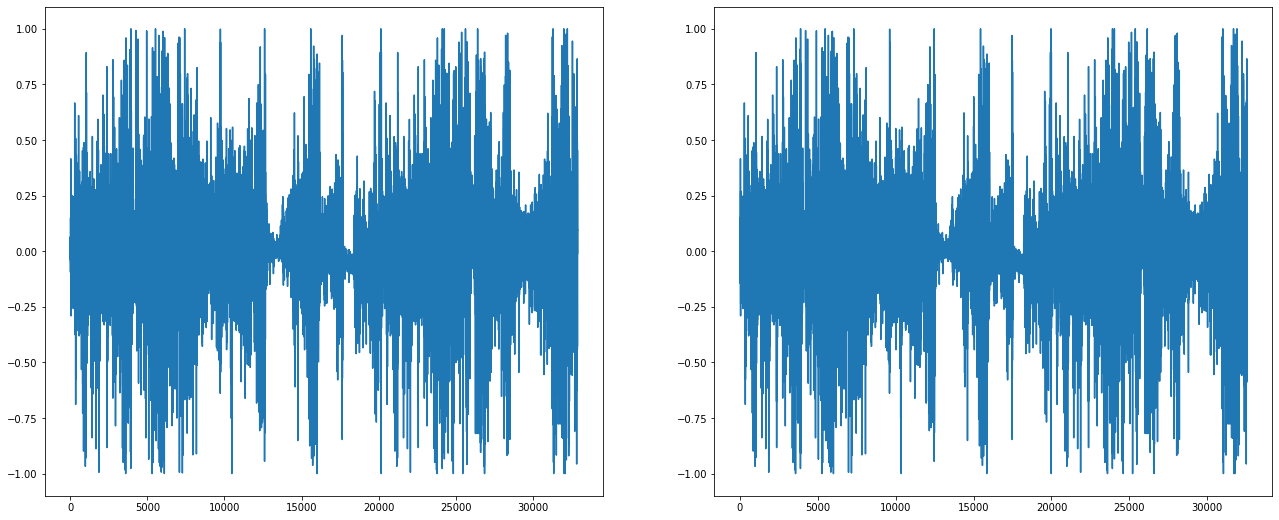

In [94]:
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.plot(df['tomo_gain'].values)

# Fit the base model

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Sanity checks

In [97]:
model.reset_states()

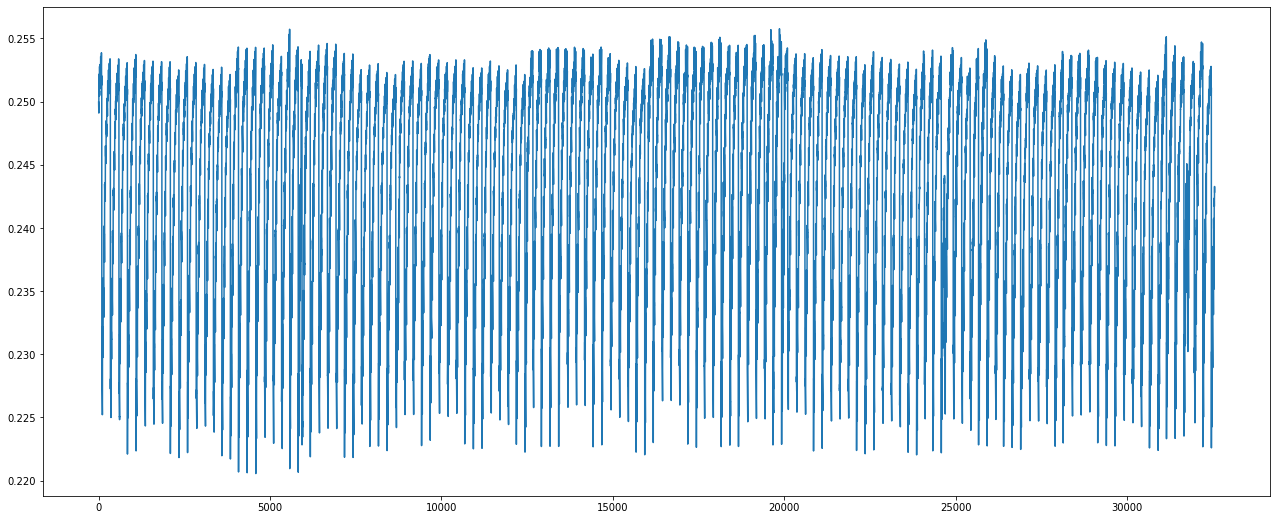

In [98]:
plt.plot(model.predict(X))

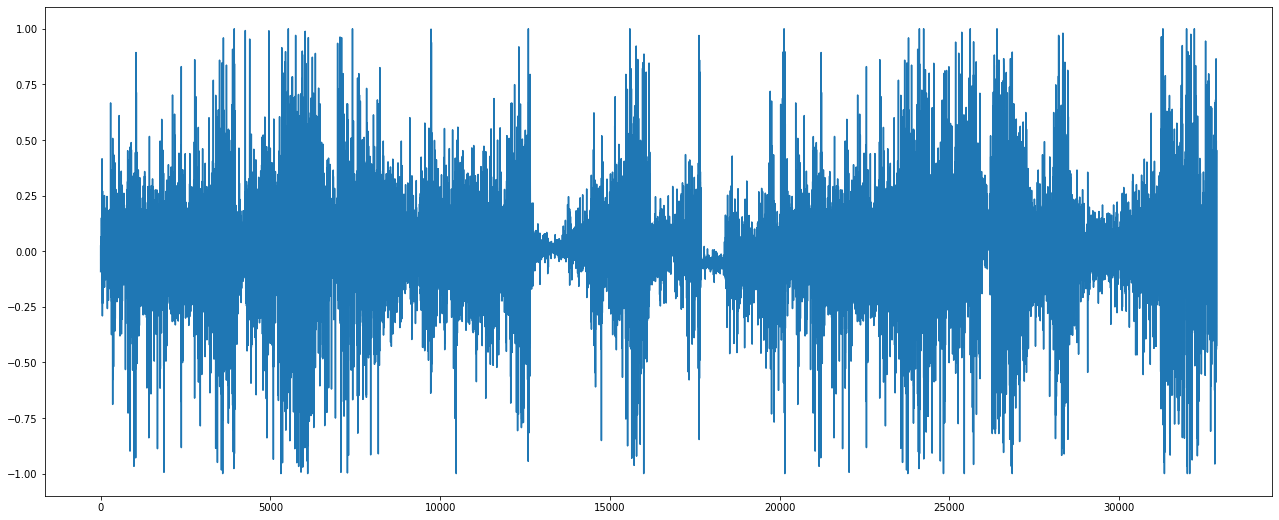

In [99]:
plt.plot(y)

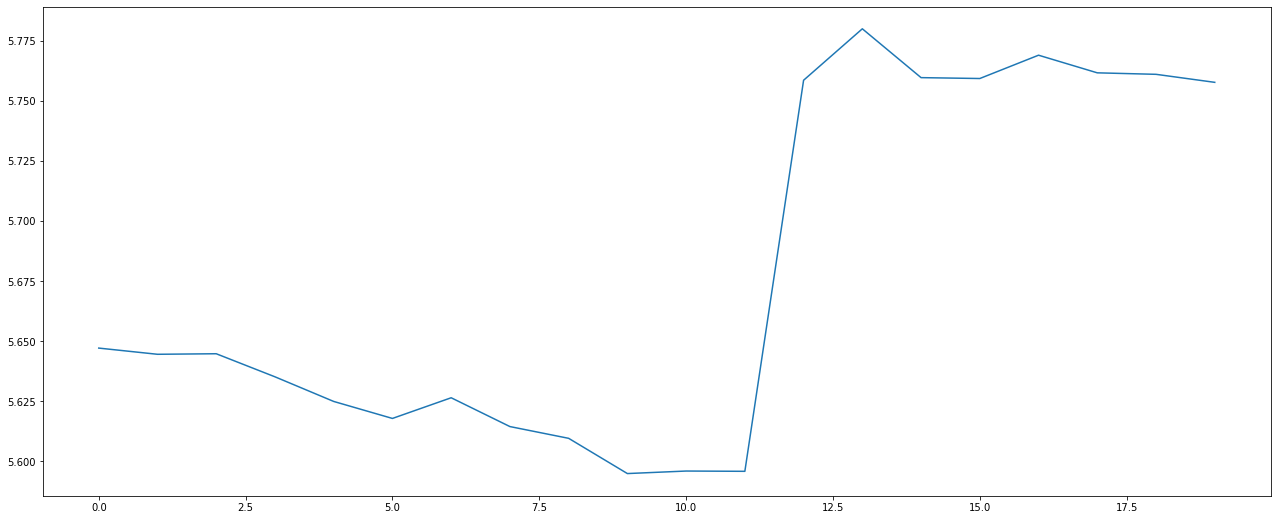

In [100]:
plt.plot(y_scalers['AAPL'].inverse_transform(model.predict(X[100:120])))

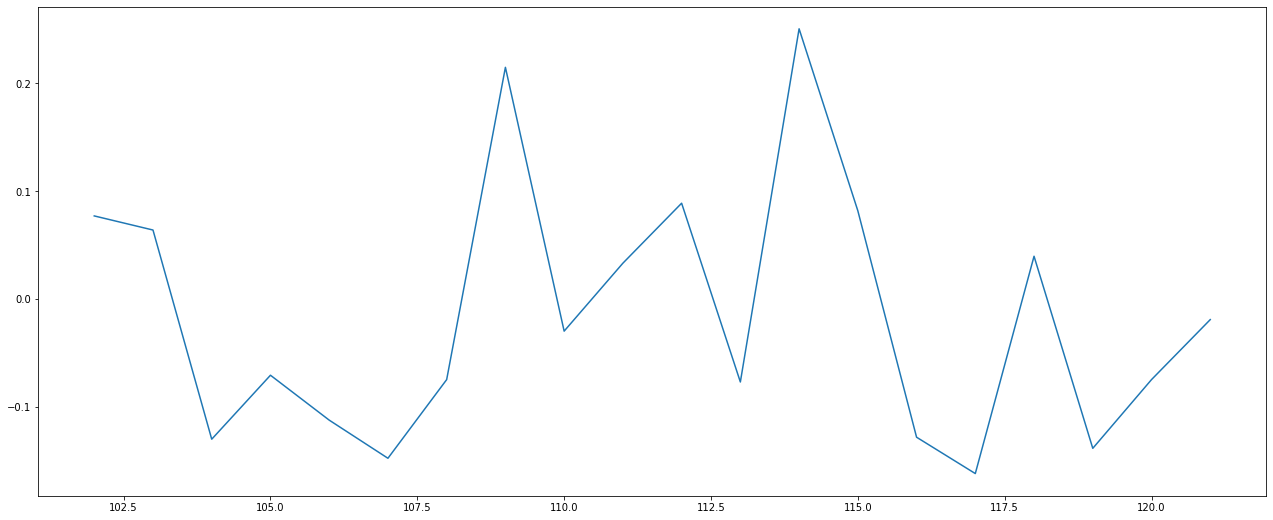

In [101]:
plt.plot(y[100:120])

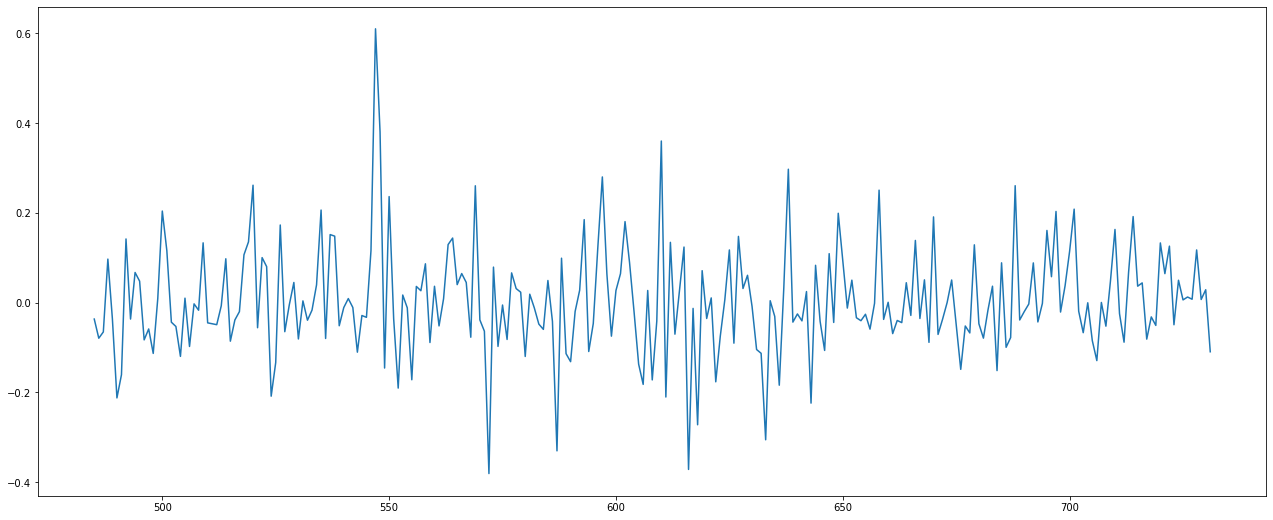

In [102]:
plt.plot(y[482:728]) # the range for TTNP

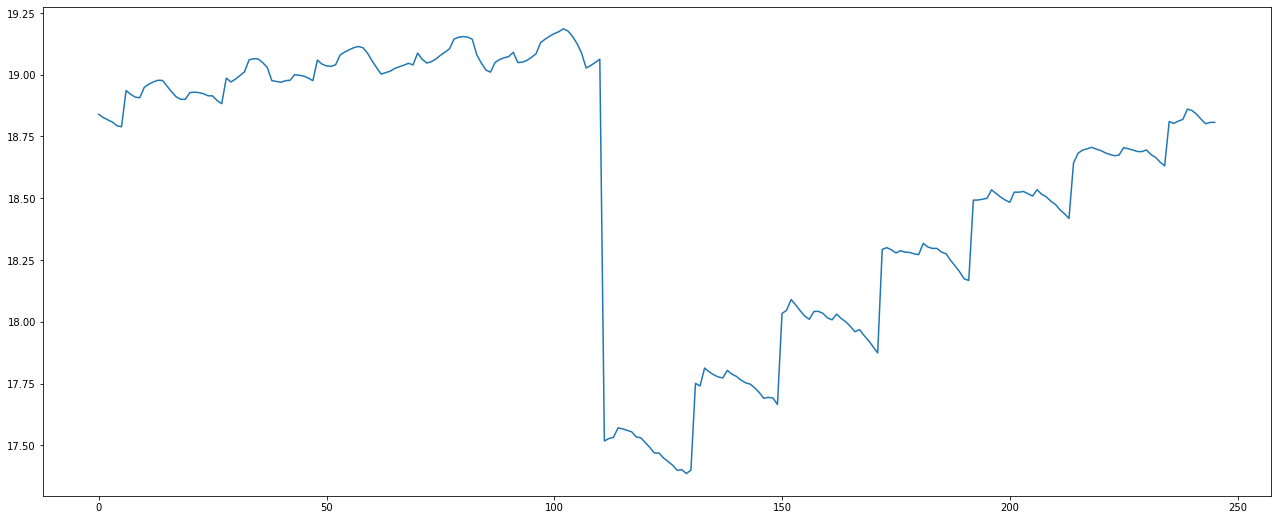

In [103]:
plt.plot(y_scalers['TSLA'].inverse_transform(model.predict(np.reshape(X[482:728], (-1, 1, num_df_cols)))))

In [104]:
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

In [105]:
pad_stock('TWTR')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [106]:
model.save('market_model.h5')

In [107]:
#model = tf.keras.models.load_model('market_model.h5')

## Pop off the model head and add a different one that we will finetune per stock

In [108]:
model.layers

In [109]:
model.pop()
model.pop()

In [110]:
# Freeze the 2 older dense layers
model.layers[0].trainable = False
model.layers[3].trainable = False

In [111]:
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

In [112]:
basket_dfs = {}
specific_models = {}
for stock in basket:
    basket_dfs[stock] = df[df['symbol'] == stock]
    specific_models[stock] = tf.keras.models.clone_model(model)
    specific_models[stock].set_weights(model.get_weights())

In [113]:
specific_models['TSLA'].layers

In [114]:
for stock in basket:
    specific_models[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [122]:
Xes = {}
ys = {}
for stock in basket:
    repeated_dummies = pad_stock(stock).reshape(1,-1).repeat(len(basket_dfs[stock]),axis=0)
    Xes[stock] = np.append(basket_dfs[stock].drop(['tomo_gain', 'symbol'], axis=1).values, repeated_dummies, axis=1)
    Xes[stock] = np.reshape(Xes[stock], (-1, 1, num_df_cols))
    ys[stock] = basket_dfs[stock]['tomo_gain'].values.reshape(-1,1)


In [123]:
Xes_train, ys_train, Xes_test, ys_test, best_model_scores, best_model = {}, {}, {}, {}, {}, {}

In [ ]:
for stock in basket:
    best_model_scores[stock] = 1e6
for stock in basket:
    Xes_train[stock] = Xes[stock][:-5]
    ys_train[stock] = ys[stock][:-5]
    Xes_test[stock] = Xes[stock][-5:]
    ys_test[stock] = ys[stock][-5:]
    for i in range(8):
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=64, epochs=100, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=16, epochs=30, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=1, epochs=1, verbose=0)
        evaluation = specific_models[stock].evaluate(Xes_test[stock], ys_test[stock])[0]
        if evaluation < best_model_scores[stock]:
            best_model_scores[stock] = evaluation
            print('now saving {} because it was the best with eval score {}'.format(stock, evaluation))
            best_model[stock] = tf.keras.models.clone_model(specific_models[stock])
            best_model[stock].set_weights(specific_models[stock].get_weights())
            best_model[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        else:
            print('did not save {} because it did not improve with eval score {}'.format(stock, evaluation))

5/1 [======================================================================================================================================================] - 0s 1ms/sample - loss: 0.0274 - mse: 0.0274
now saving TSLA because it was the best with eval score 0.02736133337020874
5/1 [======================================================================================================================================================] - 0s 1ms/sample - loss: 0.0173 - mse: 0.0173
now saving TSLA because it was the best with eval score 0.01728595606982708
5/1 [======================================================================================================================================================] - 0s 962us/sample - loss: 0.0172 - mse: 0.0172
now saving TSLA because it was the best with eval score 0.017233461141586304
5/1 [======================================================================================================================================================] - 0s 1

did not save RTX because it did not improve with eval score 0.14313192665576935
5/1 [======================================================================================================================================================] - 0s 1ms/sample - loss: 0.1313 - mse: 0.1313
now saving RTX because it was the best with eval score 0.13129834830760956
5/1 [======================================================================================================================================================] - 0s 2ms/sample - loss: 0.1575 - mse: 0.1575
did not save RTX because it did not improve with eval score 0.15751096606254578
5/1 [======================================================================================================================================================] - 1s 208ms/sample - loss: 0.0882 - mse: 0.0882
now saving TWTR because it was the best with eval score 0.08816025406122208
5/1 [============================================================================

# Now let's reassign it for simplicity

In [74]:
for stock in basket:
    specific_models[stock] = best_model[stock]

# Sanity checks

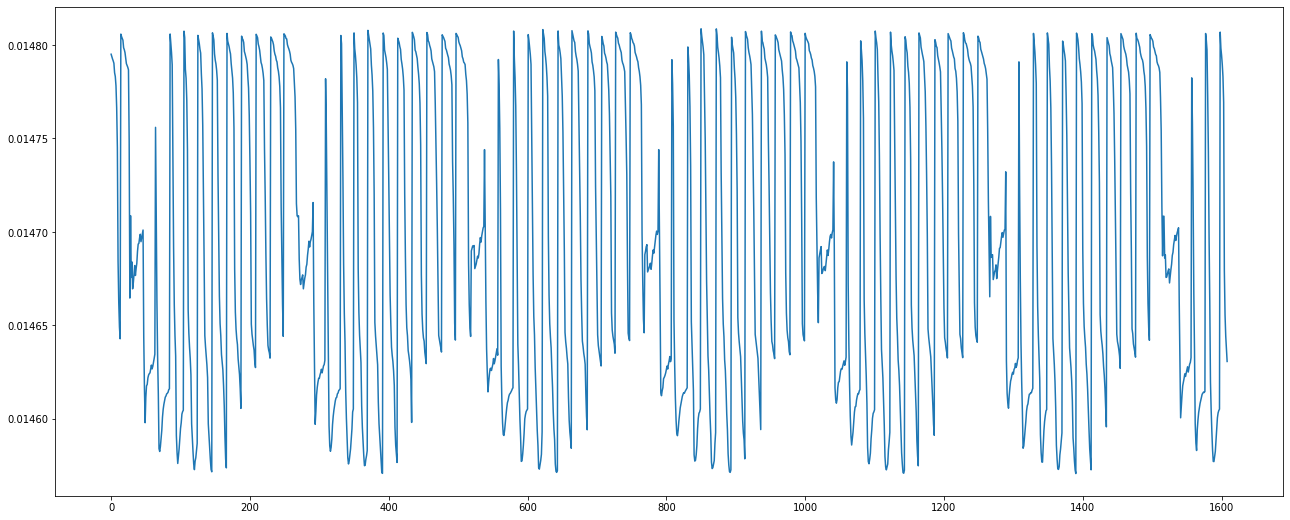

In [75]:
plt.plot(y_scalers['TWTR'].inverse_transform(specific_models['TWTR'].predict(Xes['TWTR'])))

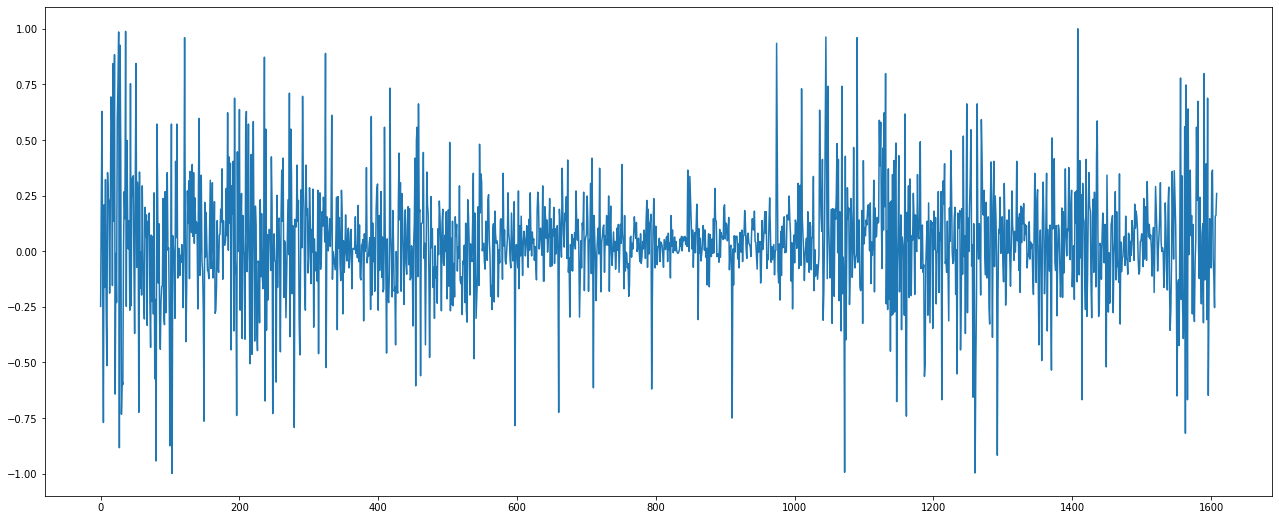

In [76]:
plt.plot(ys['TWTR'])

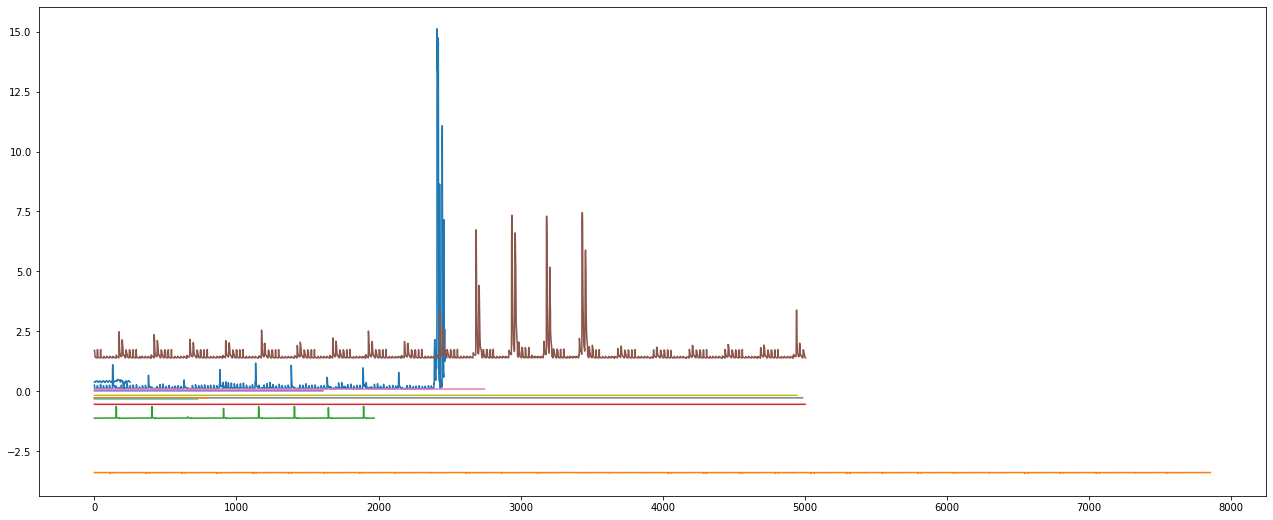

In [77]:
for stock in basket:
    plt.plot(y_scalers[stock].inverse_transform(specific_models[stock].predict(Xes[stock])))

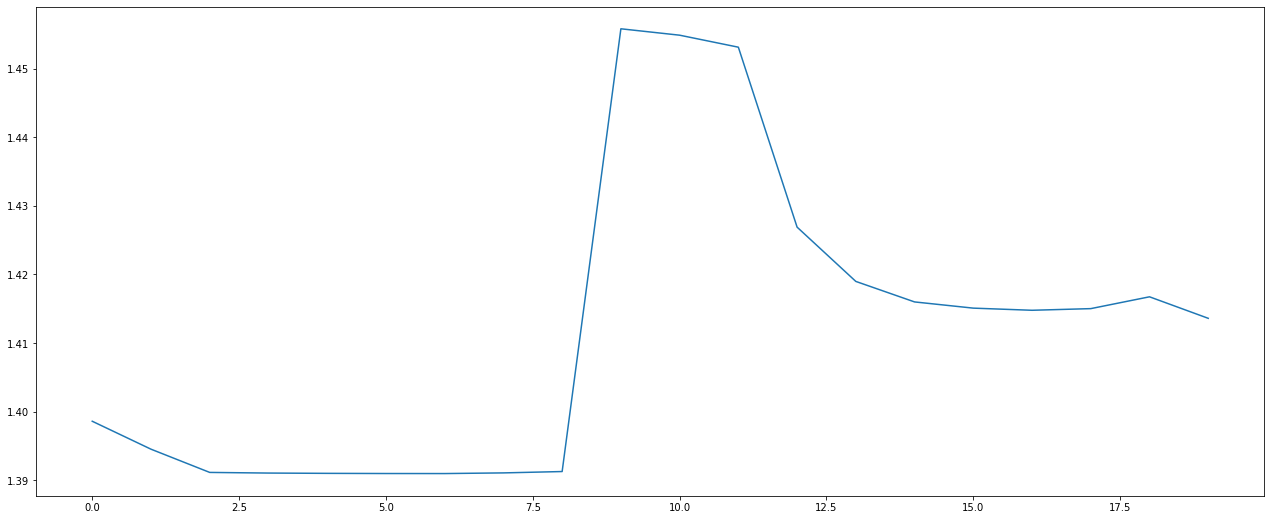

In [78]:
plt.plot(y_scalers['AAPL'].inverse_transform(specific_models['AAPL'].predict(Xes['AAPL'][100:120])))

# Make some predictions for tomorrow

I'm not sure if these have valid units by now, but definitely larger numbers mean higher gains, and v.v. Note that the RNN should be warmed up on a few previous days' data first; one-off predictions will not be as good so don't use it like this (see below instead).

In [2]:
import torch
for stock in basket:
    today = df[df['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(tf.convert_to_tensor(np.asarray(np.reshape(today, (-1, 1, num_df_cols))).astype(np.float32)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asarray(pred)))

NameError: name 'basket' is not defined

# Save the fine tuned models

In [3]:
for stock, model in specific_models.items():
    model.save('finetuned_{}.h5'.format(stock))

NameError: name 'specific_models' is not defined

# With the models built, run this to generate new predictions for the most recent day

In [4]:
X_scalers = pickle.load(open('x_scalers.pkl', 'rb'))
y_scalers = pickle.load(open('y_scalers.pkl', 'rb'))

NameError: name 'pickle' is not defined

In [291]:
specific_models = {}
for stock in basket:
    specific_models[stock] = tf.keras.models.load_model('finetuned_{}.h5'.format(stock))

In [292]:
tsla = web.DataReader("TSLA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
googl = web.DataReader("GOOGL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
fb = web.DataReader("FB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [293]:
twtr = web.DataReader("TWTR", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
rtx = web.DataReader("RTX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
aapl = web.DataReader("AAPL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [294]:
sand = web.DataReader("SAND", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
bac = web.DataReader("BAC", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
dis = web.DataReader("DIS", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [295]:
sgh = web.DataReader("SGH", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
uber= web.DataReader("UBER", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
snap = web.DataReader("SNAP", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [296]:
aapl = aapl.copy()
aapl = aapl.reset_index()

tsla = tsla.copy()
tsla=tsla.reset_index()

fb = fb.copy()
fb=fb.reset_index()

rtx = rtx.copy()
rtx=rtx.reset_index()

aapl = aapl.copy()
aapl=aapl.reset_index()

twtr = twtr.copy()
twtr = twtr.reset_index()

googl = googl.copy()
googl=googl.reset_index()

sgh = sgh.copy()
sgh=sgh.reset_index()

sand = sand.copy()
sand=sand.reset_index()

bac = bac.copy()
bac=bac.reset_index()

dis = dis.copy()
dis=dis.reset_index()

uber = uber.copy()
uber=uber.reset_index()

snap = snap.copy()
snap=snap.reset_index()




In [297]:
basket = ['TSLA', 'GOOGL', 'FB','RTX','TWTR','AAPL', 'SAND','BAC','DIS','SGH','UBER','SNAP']


aapl['symbol'] = "AAPL"
googl['symbol'] ='GOOGL'
fb['symbol'] = 'FB'
twtr['symbol'] ='TWTR'
rtx['symbol'] ='RTX'
tsla['symbol'] = 'TSLA'
sand['symbol'] = 'SAND'
bac['symbol'] = 'BAC'
dis['symbol'] = 'DIS'
sgh['symbol'] = 'SGH'
uber['symbol'] = 'UBER'
snap['symbol'] = 'SNAP'

new_day = pd.concat([googl,fb,twtr,rtx,aapl,tsla, googl, sgh, sand, bac, dis, uber, snap], ignore_index = False)
sum(new_day['symbol']=='GOOGL')
new_day.head()

,index,open,high,low,close,volume,symbol,level_0
0,2004-08-19,100.01,104.06,95.96,100.335,44659000,GOOGL,NaN
1,2004-08-20,101.01,109.08,100.50,108.310,22834300,GOOGL,NaN
2,2004-08-23,110.76,113.48,109.05,109.400,18256100,GOOGL,NaN
3,2004-08-24,111.24,111.60,103.57,104.870,15247300,GOOGL,NaN
4,2004-08-25,104.76,108.00,103.88,106.000,9188600,GOOGL,NaN


In [298]:
for stock in basket:
    days =[]
    weeks = []
    quarter = []
    as_date = []   
    for x in new_day.loc[new_day['symbol'] == stock,'index']:
        as_date.append(datetime.strptime(x, '%Y-%m-%d'))
    for date in as_date:
        days.append(date.day)
        weeks.append(date.isocalendar()[1])
        quarter.append(completed_quarter(date))
    new_day.loc[new_day['symbol'] == stock,'dayofweek'] = days
    new_day.loc[new_day['symbol'] == stock,'quarter'] = quarter
    new_day.loc[new_day['symbol'] == stock,'weekofyear'] = weeks



In [299]:
new_day.tail()

,index,open,high,low,close,volume,symbol,level_0,dayofweek,quarter,weekofyear
798,2020-05-04,16.60,17.190,16.530,17.10,17632170,SNAP,NaN,4.0,1.0,19.0
799,2020-05-05,17.17,17.755,17.122,17.51,25456512,SNAP,NaN,5.0,1.0,19.0
800,2020-05-06,17.02,17.820,17.010,17.33,25285105,SNAP,NaN,6.0,1.0,19.0
801,2020-05-07,17.60,18.170,17.530,18.15,31807805,SNAP,NaN,7.0,1.0,19.0
802,2020-05-08,18.18,18.260,17.760,18.23,19240994,SNAP,NaN,8.0,1.0,19.0


In [300]:
new_day = new_day.drop(['index'],axis =1)
new_day = new_day.dropna(axis = 1)
new_day[new_day['symbol']=='BAC']

,open,high,low,close,volume,symbol,dayofweek,quarter,weekofyear
0,48.63,50.880,48.56,50.63,5379600,BAC,15.0,1.0,20.0
1,50.94,51.630,49.19,49.69,5354200,BAC,16.0,1.0,20.0
2,49.06,49.810,48.56,49.31,3047400,BAC,17.0,1.0,20.0
3,49.38,50.810,49.31,50.31,4653300,BAC,18.0,1.0,20.0
4,49.56,50.190,49.13,49.75,4563100,BAC,19.0,1.0,20.0
...,...,...,...,...,...,...,...,...,...
5023,22.70,22.990,22.43,22.93,45807008,BAC,4.0,1.0,19.0
5024,23.48,23.515,22.62,22.66,45628101,BAC,5.0,1.0,19.0
5025,23.00,23.080,22.23,22.35,53742506,BAC,6.0,1.0,19.0
5026,22.66,23.370,22.61,22.84,51822356,BAC,7.0,1.0,19.0


In [301]:
for stock in basket:
    for col in ('close', 'high', 'low', 'open', 'volume'):
        new_day[col] = new_day[col].astype(float)
        new_day.loc[new_day['symbol'] == stock, col] = signal.detrend(new_day[new_day['symbol'] == stock][col])
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=2).mean()
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=3).mean()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=2).std()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=3).std()
new_day['tomo_gain'] = new_day['close'].shift(-1) - new_day['close']
new_day['yday_gain'] = new_day['tomo_gain'].shift(1)

In [302]:
dummies = pd.get_dummies(new_day['symbol'], columns=['symbol'])
print(new_day.shape[1])
num_new_day_cols = new_day.shape[1] - 1 + len(basket) - 1
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums
print(num_new_day_cols)

15
25


# Today: This should be better

In [303]:
import torch
for stock in basket:
    today = new_day[new_day['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(tf.convert_to_tensor(np.asarray(np.reshape(today, (-1, 1, num_new_day_cols))).astype(np.float32)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asarray(pred)))

Stock TSLA, pred: [[4.9625587]]
Stock GOOGL, pred: [[3.8406274]]
Stock FB, pred: [[0.10259001]]
Stock RTX, pred: [[0.9925935]]
Stock TWTR, pred: [[0.6203761]]
Stock AAPL, pred: [[0.16787489]]
Stock SAND, pred: [[-0.01509852]]
Stock BAC, pred: [[0.1498336]]
Stock DIS, pred: [[-0.16147996]]
Stock SGH, pred: [[0.47801626]]
Stock UBER, pred: [[0.5123019]]
Stock SNAP, pred: [[0.3362351]]
